### Assignment 4.1: Mean dynamic topography & sea level

In this assignment, you will use two satellite altimetry products: the mean dynamic topography and gridded sea-level anomalies. 

You can download the mean dynamic topography product of AVISO from Blackboard *[to-do]*.

To download the gridded sea-level anomalies, register [here](https://data.marine.copernicus.eu/register?redirect=%2Fproducts). Then, download the sea-level anomalies by clicking on the download symbol (top right) at [this](https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description) webpage. Select the dataset with monthly means (ending with P1M-m), the <code>Sea surface height above sea level (sla)</code> variable, in the time period 01-01-1995 to 31-12-2015, for the entire globe.

Open the mean dynamic topography using xarray (like in the previous exercises).

**a)** Make a figure with maps of the mean dynamic topography and corresponding geostrophic velocities (<code>U</code> and <code>V</code> variables). Describe the relationship between the mean dynamic topography and the geostrophic velocities.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cmocean

In [2]:
# open u & v wind stress and compute the annual mean
datadir ='/Users/timhermans/Documents/Data/CNES_MDT_CLS/'
mdt = xr.open_dataset(os.path.join(datadir,'dataset-mdt-cnes-cls18-global_1675069242978.nc'))

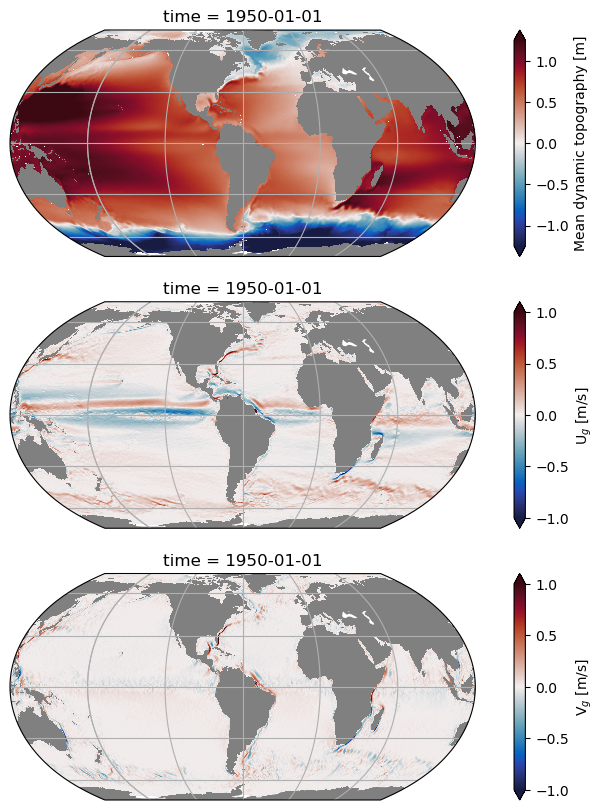

In [3]:
f, ax = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=300)))

#plot sverdrup streamfunction
mdt.mdt.plot(cmap=cmocean.cm.balance,vmin=-1.25,vmax=1.25,transform=ccrs.PlateCarree(),ax=ax[0],cbar_kwargs={'label':'Mean dynamic topography [m]'})
ax[0].gridlines()
ax[0].add_feature(cfeature.LAND, color='grey')

#plot geostrophic velocities (as in Exerise A04)
mdt.u.isel(time=0).plot(cmap=cmocean.cm.balance,vmin=-1,vmax=1,transform=ccrs.PlateCarree(),ax=ax[1],cbar_kwargs={'label':'U$_{g}$ [m/s]'})
ax[1].gridlines()
ax[1].add_feature(cfeature.LAND, color='grey')

mdt.v.isel(time=0).plot(cmap=cmocean.cm.balance,vmin=-1,vmax=1,transform=ccrs.PlateCarree(),ax=ax[2],cbar_kwargs={'label':'V$_{g}$ [m/s]'})
ax[2].gridlines()
ax[2].add_feature(cfeature.LAND, color='grey')


>ANSWER: the currents flow arround gradients in the MDT

Now also open the gridded sea-level anomalies. Satellites have measured changes in sea level since 1993. One way to look at these changes is by looking at linear trends of the sea level anomalies.

In [38]:
datadir ='/Users/timhermans/Documents/Data/AVISO/'
sla = xr.open_dataset(os.path.join(datadir,'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_1675069845599.nc'))

sla_coarse = xr.open_dataset(os.path.join(datadir,'sla_coarse.nc'))

**b)** Compute and plot a map of the linear regression coefficients of the sea-level anomalies. Describe what you see.

Hints:
- To do a linear regression, you can use a function like <code>np.polyfit()</code>.
- To compute a trend at each grid cell, you can either loop over all grid cells or use <code>xr.apply_ufunc()</code> to apply a custom function to your xarray dataset. The following code gives you an example:

```python
def fit_linear(data, time): 
    
    #coefficient,intercept = implement your regression here
    
    return np.array([coefficient,intercept])

example = xr.apply_ufunc(
        fit_linear, sla.sla, np.arange(len(sla.time)),
        input_core_dims=[["time"], ["time"]], #core dimension: time
        output_core_dims=[["coefs"]], #outputs 1st degree coefficient and intercept
        vectorize=True, 
        dask='allowed',
        output_dtypes=[float],
        output_sizes={"coefs": 2}
        )
```

In [39]:
def fit_linear(data, time): 
    
    pfit = np.polyfit(time, data,1) 
    
    return np.array([pfit[0],pfit[1]])

linear_fits = xr.apply_ufunc(
        fit_linear, sla_coarse.sla, np.arange(len(sla.time)),
        input_core_dims=[["time"], ["time"]], #core dimension: time
        output_core_dims=[["coefs"]], #outputs 1st degree coefficient and intercept
        vectorize=True, 
        dask='allowed',
        output_dtypes=[float],
        output_sizes={"coefs": 2}
        )

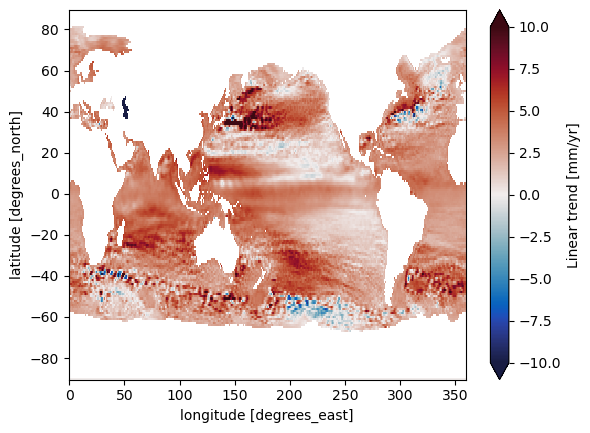

In [40]:
(12*1000*linear_fits.isel(coefs=0)).plot(vmin=-10,vmax=10,cmap=cmocean.cm.balance,cbar_kwargs={'label':'Linear trend [mm/yr]'})

In [19]:
fit = sla.sla.polyfit(dim='time',deg=1,skipna=True).polyfit_coefficients.isel(degree=0)

/opt/anaconda3/envs/postdoc/lib/python3.10/site-packages/xarray/core/nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [41]:
sla.time

<xarray.DataArray 'time' (time: 252)>
array(['1995-01-15T00:00:00.000000000', '1995-02-15T00:00:00.000000000',
       '1995-03-15T00:00:00.000000000', ..., '2015-10-15T00:00:00.000000000',
       '2015-11-15T00:00:00.000000000', '2015-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-01-15 1995-02-15 ... 2015-12-15
Attributes:
    axis:                 T
    bounds:               climatology_bnds
    long_name:            Time
    standard_name:        time
    _ChunkSizes:          1
    _CoordinateAxisType:  Time
    valid_min:            16450.0
    valid_max:            24089.0

In [52]:
sla = sla.where(np.isfinite(sla.sla).all(dim='time'))

In [53]:
sla['time'] = np.arange(len(sla.time))
fit = sla.sla.polyfit(dim='time',deg=1)


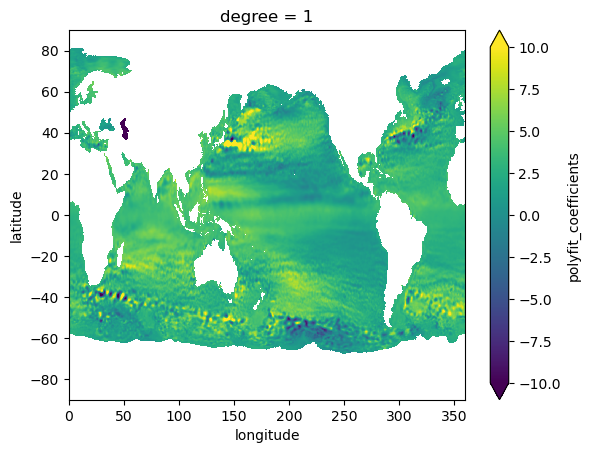

In [54]:
(1000*12*fit).polyfit_coefficients.isel(degree=0).plot(vmin=-10,vmax=10)

In [50]:
fit

<xarray.Dataset>
Dimensions:               (latitude: 720, longitude: 1440, degree: 2)
Coordinates:
  * latitude              (latitude) float64 -89.88 -89.62 ... 89.62 89.88
  * longitude             (longitude) float64 0.125 0.375 0.625 ... 359.6 359.9
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 nan nan ... nan

>Answer: sea level has been rising in most of the oceans, eddy-active regions stand out.